take sweeps with ZI and move across the beam

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.signal import argrelmax
from os import listdir
from os.path import isfile, join
%matplotlib inline
import threading

import json

# add additional path to import scripts used in gui
import sys
sys.path.append('C:/Users/Experiment/PycharmProjects/PythonLab')

import hardware_modules.ZiControl as zi
import functions.ScanPhotodiode_DAQ as GalvoScan
import hardware_modules.PiezoController as pc
import functions.tracking as trk
from  hardware_modules.GalvoMirrors import SetGalvoPoint
# from  hardware_modules.PhotodiodeInput import ReadPhotodiode
import hardware_modules.PhotodiodeInput as PDIn



from time import localtime, strftime
import time
# file = './2015-05-21_20-32-29-5.8e-4Torr_NoPinhole_R100k.csv'
# folder = './'


timePerPt = 0.001

# Measure the full image

In [2]:
# =============================================
# =============================================
# set the initial scan range
# =============================================
rio_initial = {
        "xo": 0, 'yo': 0,
        "dx": 0.8, 'dy': 0.8,
        'xPts': 120, 'yPts': 120
    }



xVmin,xVmax,xPts,yVmin,yVmax,yPts = trk.rio_to_galvoparameter(rio_initial)

scanner = GalvoScan.ScanNV(xVmin,xVmax,xPts,yVmin,yVmax,yPts,timePerPt, canvas = None)

image_data = scanner.scan()

# set RoI

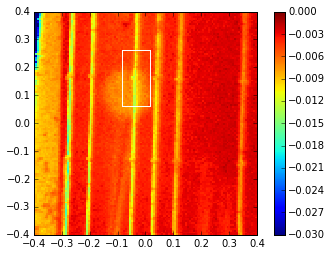

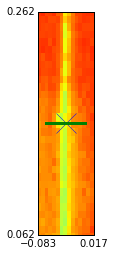

In [3]:
# =============================================
# =============================================
# display image 
# =============================================

# ---------------------------------------------
# adjust the color scale
clim_min, clim_max = -0.03, 0
# ---------------------------------------------

# ---------------------------------------------
# set region of interest

# rio = {
#         "xo": -0.035, 'yo': 0.165,
#         "dx": 0.1, 'dy': 0.2,
#         'xPts': 30, 'yPts': 60
#     }

rio = {
        "xo": -0.033, 'yo': 0.162,
        "dx": 0.1, 'dy': 0.2,
        'xPts': 30, 'yPts': 60
    }
# ---------------------------------------------

# =============================================
# =============================================

xo_array = np.linspace(-0.070,-0.00,36)



# ---------------------------------------------
# show image
fig_overwiew = plt.figure()
ax = plt.subplot(1,1,1)


X, Y = np.meshgrid( np.linspace(xVmin,xVmax,xPts),  np.linspace(yVmin,yVmax,yPts))

p = plt.pcolor(X, Y, image_data)
# p = plt.imshow(image_data, interpolation="nearest")
plt.colorbar()
p.set_clim(clim_min, clim_max)
plt.xlim([xVmin, xVmax])
plt.ylim([yVmin, yVmax])

# plt.axes().set_aspect('equal')

plt.axes().set_aspect(abs((xVmax-xVmin) / (yVmax-yVmin)))
# print abs((xVmax-xVmin) / (yVmax-yVmin))
# ---------------------------------------------
# draw RIO
trk.plot_region(plt, rio, color = 'w')

#  plot close up
fig_RoI = plt.figure()
ax = plt.subplot(1,1,1)
p = plt.pcolor(X, Y, image_data)
# p = plt.imshow(image_data, interpolation="nearest")
# plt.colorbar()
p.set_clim(clim_min, clim_max)

rio_xVmin, rio_xVmax, rio_xPts, rio_yVmin, rio_yVmax, rio_yPts = trk.rio_to_galvoparameter(rio)

plt.xlim([rio_xVmin, rio_xVmax])
plt.ylim([rio_yVmin, rio_yVmax])
plt.axes().set_xticks([rio_xVmin, rio_xVmax])
plt.axes().set_yticks([rio_yVmin, rio_yVmax])

plt.axes().set_aspect(rio_yPts / rio_xPts)
plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20)

plt.plot([np.min(xo_array), np.max(xo_array)], [rio['yo'], rio['yo']], '-' , lw = 3)

#  loop over different xo positions, don't correct for drifts

autoConnect connected to a server on port 8005 using API level 1.
autoDetect selected the device dev35 for the measurement.
[['/dev35/sigins/0/imp50', 1], ['/dev35/sigins/0/ac', 0], ['/dev35/sigins/0/range', 2], ['/dev35/demods/0/order', 4], ['/dev35/demods/0/rate', 10000.0], ['/dev35/demods/0/harmonic', 1], ['/dev35/demods/0/phaseshift', 0], ['/dev35/sigouts/0/on', 1], ['/dev35/sigouts/0/range', 1], ['/dev35/sigouts/0/enables/6', 1], ['/dev35/sigouts/0/amplitudes/6', 1.0], ['/dev35/AUXOUTS/0/OFFSET', 2], ['/dev35/oscs/0/freq', 100000.0], ['/dev35/demods/0/oscselect', 0], ['/dev35/demods/0/adcselect', 0], ['/dev35/sigins/0/diff', 0], ['/dev35/sigouts/0/add', 1]]
2015-06-03 15:44:54
current xo: -0.070V
Will perform 1 sweeps....
Individual sweep 100.00% complete.   
sample contains 1 sweeps
2015-06-03 15:48:22
current xo: -0.068V
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-03 15:51:51
current xo: -0.066V
Will perform 1 sweeps....

sample contains 1 sweeps
2015-06-03 15:55

C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:423: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


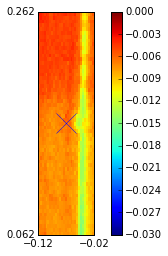

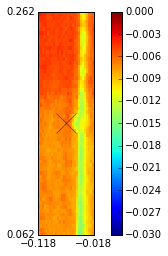

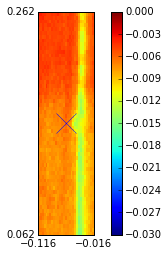

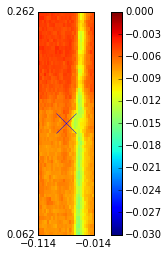

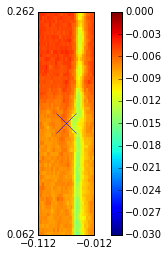

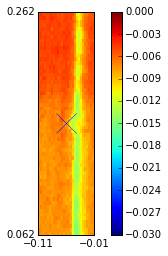

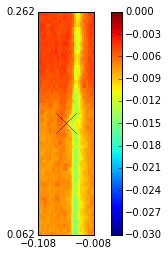

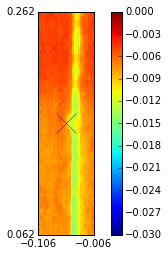

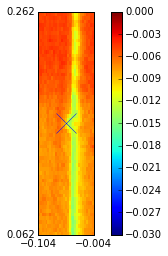

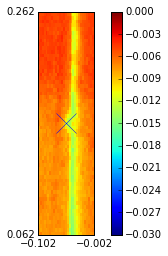

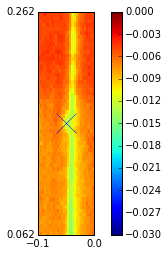

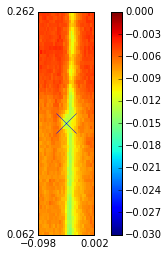

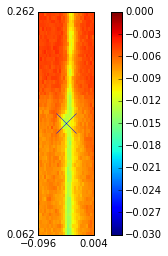

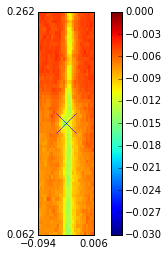

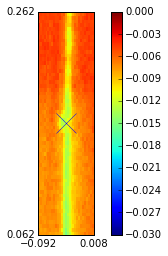

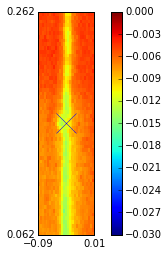

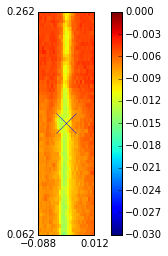

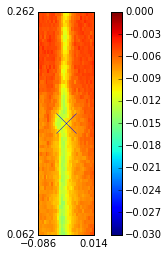

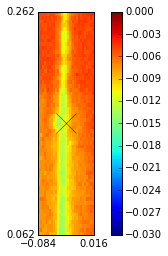

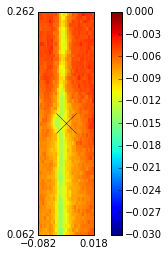

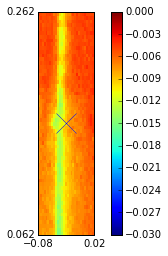

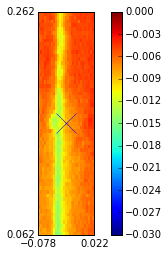

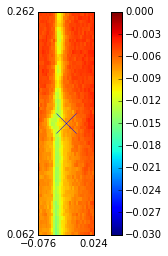

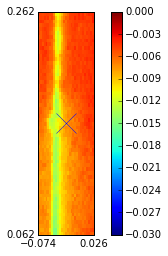

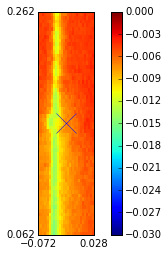

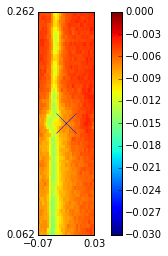

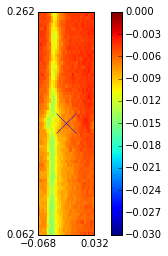

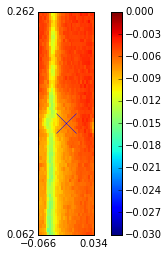

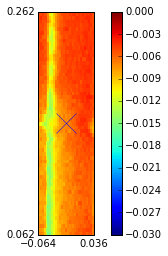

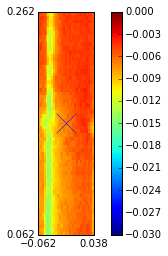

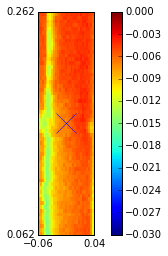

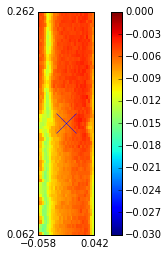

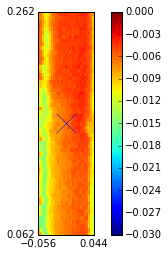

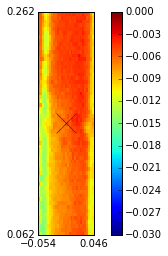

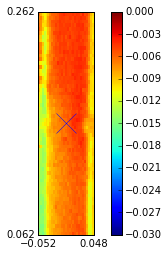

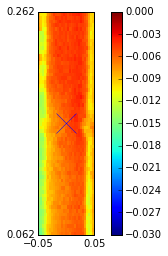

In [4]:
fo = 1.94065e6
df = 1800.

dirpath = 'Z:/Lab/Cantilever/Measurements/150526_Silicon_nitride_with_1um_pads/MoveFocus/'
tag = 'Si3Ni4'

start_time = strftime("%Y-%m-%d_%H-%M-%S", localtime())
filename = '{:s}_{:s}'.format(start_time,tag) 

# ========================================================================================
# define new interval for sweep 
sweep_parameter = {
    'freqStart' : fo - df/2.,
    'freqEnd' : fo + df/2.,
    'sampleNum' : 451,
    'samplesPerPt' : 8, 
    'xScale' : 0,
    'direction' : 0,
    'loopcount': 1,
    'timeout' : 1e8
}


with open('{:s}.sweep'.format('{:s}/{:s}'.format(dirpath, filename)), 'w') as outfile:
    json.dump(sweep_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


amplitude = 1


zi_parameter = {
    'amplitude' : amplitude,
    'offset' : amplitude + 1,
    'freq' : 1e5,
    'ACCoupling' : 0, 
    'inChannel' : 0,
    'outChannel' : 0,
    'auxChannel': 0,
    'add' : 1,
    'range' : 10**int(np.ceil(np.log10(amplitude)))
}



with open('{:s}.zi'.format('{:s}/{:s}'.format(dirpath, filename)), 'w') as outfile:
    json.dump(zi_parameter, outfile, sort_keys = True, indent = 4, ensure_ascii=False)

zi_hf2 = zi.ZIHF2(zi_parameter['amplitude'],
                  zi_parameter['offset'],
                  zi_parameter['freq'],
                  zi_parameter['ACCoupling'],
                  zi_parameter['inChannel'],
                  zi_parameter['outChannel'],
                  zi_parameter['auxChannel'],
                  zi_parameter['add'],
                  zi_parameter['range']
                 )


# ======================================================================
# start script =========================================================
# ======================================================================

for xo in xo_array:
    print strftime("%Y-%m-%d %H:%M:%S", localtime())
    
    full_filename = '{:s}/{:s}_xo_{:00.3f}V'.format(dirpath, filename, xo)

    
    rio = {
            "xo": xo, 'yo': 0.162,
            "dx": 0.1, 'dy': 0.2,
            'xPts': 30, 'yPts': 60
        }
    
    print 'current xo: {:00.3f}V'.format(xo)

    # ---------------------------------------------
    # scan RIO
    rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts = trk.rio_to_galvoparameter(rio)
    scanner = GalvoScan.ScanNV(rio_xVmin,rio_xVmax,rio_xPts,rio_yVmin,rio_yVmax,rio_yPts,timePerPt, canvas = None)
    rio_image_data = scanner.scan()


    # ---------------------------------------------
    # show image

    # fig = plt.figure(figsize=(20,10))


    fig_RoI = plt.figure()
    X, Y = np.meshgrid( np.linspace(rio_xVmin,rio_xVmax,rio_xPts),  np.linspace(rio_yVmin,rio_yVmax,rio_yPts))

    p = plt.pcolor(X, Y, rio_image_data)
    # p = plt.imshow(image_data, interpolation="nearest")
    plt.colorbar()
    p.set_clim(clim_min, clim_max)

    plt.xlim([rio_xVmin, rio_xVmax])
    plt.ylim([rio_yVmin, rio_yVmax])

    plt.axes().set_aspect(rio_yPts / rio_xPts)
    plt.plot(rio['xo'], rio['yo'], 'x' , ms = 20, mew = 0.5)
    # plt.plot(rio['xo'], rio['yo'], 'circ' , ms = 20, mew = 2)
    plt.axes().set_xticks([rio_xVmin, rio_xVmax])
    plt.axes().set_yticks([rio_yVmin, rio_yVmax])
    # save RIO image and data
    counter = 0
    
    fig_RoI.savefig('{:s}.png'.format(full_filename))
    np.savetxt('{:s}.csv'.format(full_filename), rio_image_data, fmt='%.18e', delimiter=',')

    with open('{:s}.rio'.format(full_filename), 'w') as outfile:
         json.dump(rio, outfile, sort_keys = True, indent = 4, ensure_ascii=False)


    # ========================================================================================
    # set laser position
    SetGalvoPoint(rio['xo'], rio['yo']) 

    # ========================================================================================
    # look for mechanical resonance and save sweep data

    zi_hf2.sweep(sweep_parameter['freqStart'],
                 sweep_parameter['freqEnd'],
                 sweep_parameter['sampleNum'],
                 sweep_parameter['samplesPerPt'],
                 sweep_parameter['xScale'],
                 sweep_parameter['direction'],
                 sweep_parameter['loopcount'],
                 sweep_parameter['timeout']
                )



    zi_hf2.writeData('{:s}.dat'.format(full_filename).format(full_filename))



(-0.0, 0.162)

In [8]:
SetGalvoPoint(-0.054, rio['yo']) 

<hardware_modules.GalvoMirrors.SetGalvoPoint instance at 0x000000001A923E48>

In [7]:
-0.054, rio['yo']

(-0.054, 0.162)